# **Air Temperature Time Series**

### **1. Problem Statement**

In this project, we aim to develop an AI model capable of predicting the surface air temperature for the upcoming month.

The prediction will be based on the mean temperature data from the previous month.

### **2. Domain Analysis**

Surface air temperature is a crucial parameter in weather forecasting and climate monitoring. It is influenced by various factors, including geographic location, altitude, time of year, and atmospheric conditions. Understanding and predicting temperature changes can help mitigate risks associated with extreme weather events, optimize agricultural practices, and manage energy resources more efficiently.

### **3. Data Collection and Preprocessing**
Download the dataset:<a href=" https://d3ilbtxij3aepc.cloudfront.net/projects/AI-Capstone-Projects/PRAICP-1003-AirTempTS.zip"> Air Temperature Time Series<a/>

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import and Unzip the file
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/air-temp.zip'

# Directory where you want to extract the contents
airtemp = '/content/extracted_folder'

# Create the directory if it doesn't exist
os.makedirs(airtemp, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(airtemp)

In [3]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Install necessary libs
!pip install statsmodels pandas matplotlib

### **4. Load the dataset**

In [4]:
data = pd.read_csv("/content/extracted_folder/air-temp/surface-air-temperature-monthly-mean.csv")

In [5]:
data.head()

,month,mean_temp
0,1982-01,25.9
1,1982-02,27.1
2,1982-03,27.2
3,1982-04,27.0
4,1982-05,28.0


In [6]:
# Convert the month column to datetime format and set it as index
data['month'] = pd.to_datetime(data['month'])
data.set_index('month', inplace=True)

In [7]:
data.sample(10)

,mean_temp
month,
2008-11-01,27.3
2012-08-01,27.9
2011-12-01,26.6
1989-10-01,27.1
2010-12-01,26.8
1993-05-01,28.2
1982-09-01,27.9
1987-05-01,27.6
1998-03-01,29.5


In [8]:
# Shape of data
data.shape

(462, 1)

In [9]:
# Get the inforamtion of data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1982-01-01 to 2020-06-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


### **5. Trend Visualization**

### **Visualization without seasonal trends**

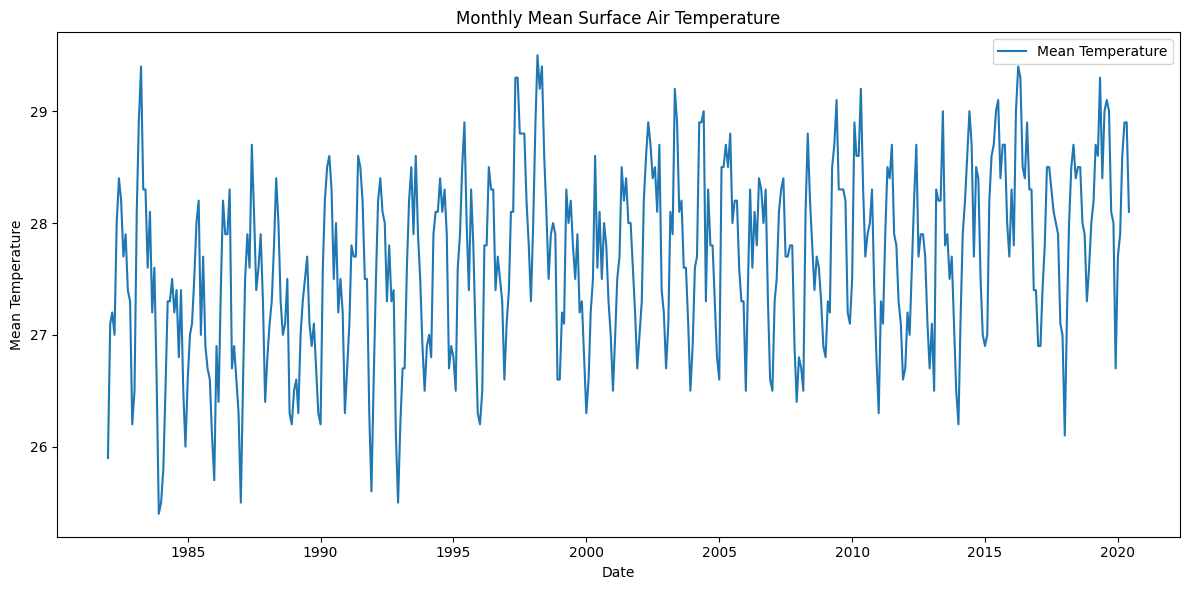

In [10]:
# Plot the time series to visualize trends and seasonality
plt.figure(figsize=(12,6))
plt.plot(data.index, data['mean_temp'], label='Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Monthly Mean Surface Air Temperature')
plt.legend()
plt.tight_layout()
plt.show()

### **Visualization with seasonal trends**

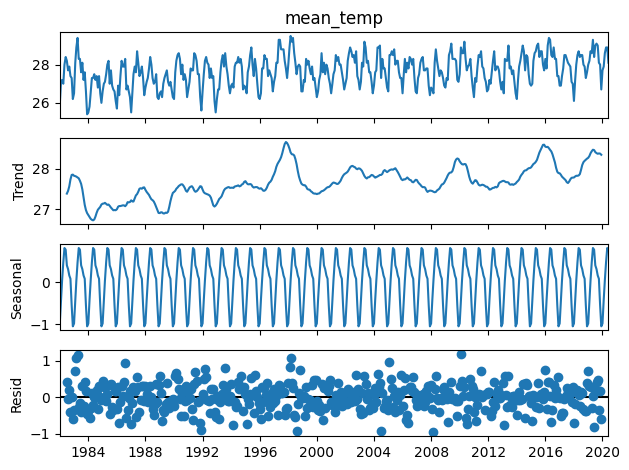

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(data['mean_temp'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

**Observation:**
The time series plot and decomposition reveal the following:

Trend: There appears to be a noticeable trend in the data, which indicates either an overall increase or decrease in temperature over time.

Seasonality: There is a clear seasonal pattern, with temperatures rising and falling in a regular, predictable manner each year.

Residuals: The residual component shows the noise or irregularities not captured by the trend or seasonal components.

### **6. Model fit**

In [ ]:
# Define and fit the SARIMA model
model_sarima = SARIMAX(data['mean_temp'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = model_sarima.fit(disp=False)
print(sarima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          mean_temp   No. Observations:                  462
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -240.898
Date:                            Mon, 08 Jul 2024   AIC                            491.797
Time:                                    15:25:19   BIC                            512.173
Sample:                                01-01-1982   HQIC                           499.839
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1983      0.064      3.115      0.002       0.074       0.323
ma.L1         -0.7916      0.042   

### **7. Data Preprocessing**

In [12]:
# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['mean_temp']])

In [13]:
# Convert data to supervised learning format
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_dataset(data_scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [14]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


### **8. Model Creation**

In [ ]:
# Define and fit the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(400, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(200))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_lstm.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/500
9/9 [==============================] - 8s 253ms/step - loss: 0.1002 - val_loss: 0.0447
Epoch 2/500
9/9 [==============================] - 0s 16ms/step - loss: 0.0425 - val_loss: 0.0307
Epoch 3/500
9/9 [==============================] - 0s 15ms/step - loss: 0.0417 - val_loss: 0.0294
Epoch 4/500
9/9 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0283
Epoch 5/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0392 - val_loss: 0.0275
Epoch 6/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0367 - val_loss: 0.0293
Epoch 7/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0375 - val_loss: 0.0273
Epoch 8/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0398 - val_loss: 0.0275
Epoch 9/500
9/9 [==============================] - 0s 15ms/step - loss: 0.0366 - val_loss: 0.0337
Epoch 10/500
9/9 [==============================] - 0s 12ms/step - loss: 0.0403 - val_loss: 0.0363
Epoch 11/500
9/9 [

In [ ]:
# Combine SARIMA and LSTM predictions
forecast_steps = 12

In [ ]:
# SARIMA forecast
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
sarima_forecast_mean = sarima_forecast.predicted_mean

In [ ]:
# LSTM forecast
last_data = data_scaled[-look_back:]
lstm_forecast = []
for _ in range(forecast_steps):
    lstm_input = last_data.reshape((1, look_back, 1))
    lstm_pred = model_lstm.predict(lstm_input)
    lstm_forecast.append(lstm_pred[0, 0])
    last_data = np.append(last_data[1:], lstm_pred)

lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Combine forecasts by averaging
combined_forecast = (sarima_forecast_mean.values + lstm_forecast) / 2

### **9. Data Prediction visualization**

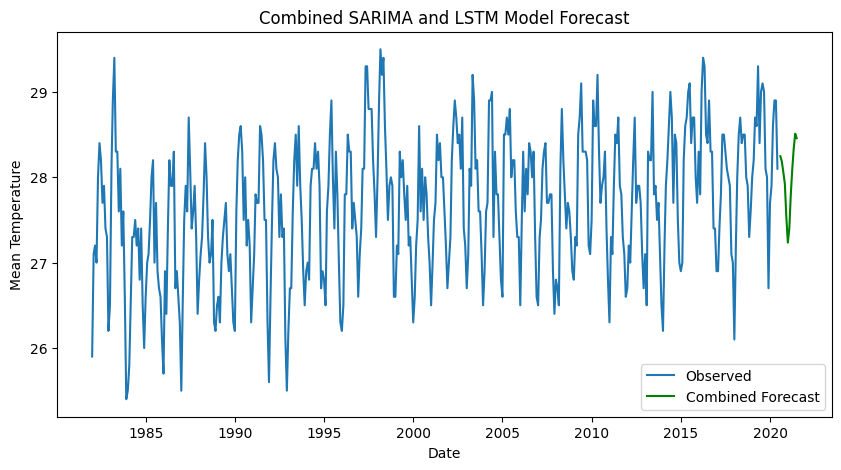

In [ ]:
# Plot the combined forecast
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['mean_temp'], label='Observed')
plt.plot(forecast_index, combined_forecast, label='Combined Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Combined SARIMA and LSTM Model Forecast')
plt.legend()
plt.show()

### **10. Model saving**

In [ ]:
# Save the models
sarima_fit.save('sarima_model.pkl')
model_lstm.save('lstm_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler.pkl']

### **11. Model Evaluation**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Evaluate SARIMA model on test data
sarima_test_forecast = sarima_fit.get_forecast(steps=len(Y_test))
sarima_test_mean = sarima_test_forecast.predicted_mean

In [ ]:
# Evaluate LSTM model on test data
lstm_test_predictions = model_lstm.predict(X_test)
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)

3/3 [==============================] - 0s 6ms/step


In [ ]:
# Combine test predictions by averaging
combined_test_predictions = (sarima_test_mean.values + lstm_test_predictions.flatten()) / 2

In [ ]:
# Calculate evaluation metrics
sarima_mse = mean_squared_error(Y_test, sarima_test_mean)
sarima_mae = mean_absolute_error(Y_test, sarima_test_mean)
sarima_rmse = np.sqrt(sarima_mse)

lstm_mse = mean_squared_error(Y_test, lstm_test_predictions)
lstm_mae = mean_absolute_error(Y_test, lstm_test_predictions)
lstm_rmse = np.sqrt(lstm_mse)

combined_mse = mean_squared_error(Y_test, combined_test_predictions)
combined_mae = mean_absolute_error(Y_test, combined_test_predictions)
combined_rmse = np.sqrt(combined_mse)

In [ ]:
print(f"SARIMA Test MSE: {sarima_mse:.4f}, SARIMA Test MAE: {sarima_mae:.4f},SARIMA Test RMSE: {sarima_rmse:.4f}")
print(f"LSTM Test MSE: {lstm_mse:.4f}, LSTM Test MAE: {lstm_mae:.4f}, LSTM Test RMSE: {lstm_rmse:.4f}")
print(f"Combined Test MSE: {combined_mse:.4f}, Combined Test MAE: {combined_mae:.4f}, Combined Test RMSE: {combined_rmse:.4f}")

SARIMA Test MSE: 757.0475, SARIMA Test MAE: 27.5054,SARIMA Test RMSE: 27.5145
LSTM Test MSE: 740.0771, LSTM Test MAE: 27.2014, LSTM Test RMSE: 27.2044
Combined Test MSE: 748.2723, Combined Test MAE: 27.3534, Combined Test RMSE: 27.3546


### **12. Prediction test data**

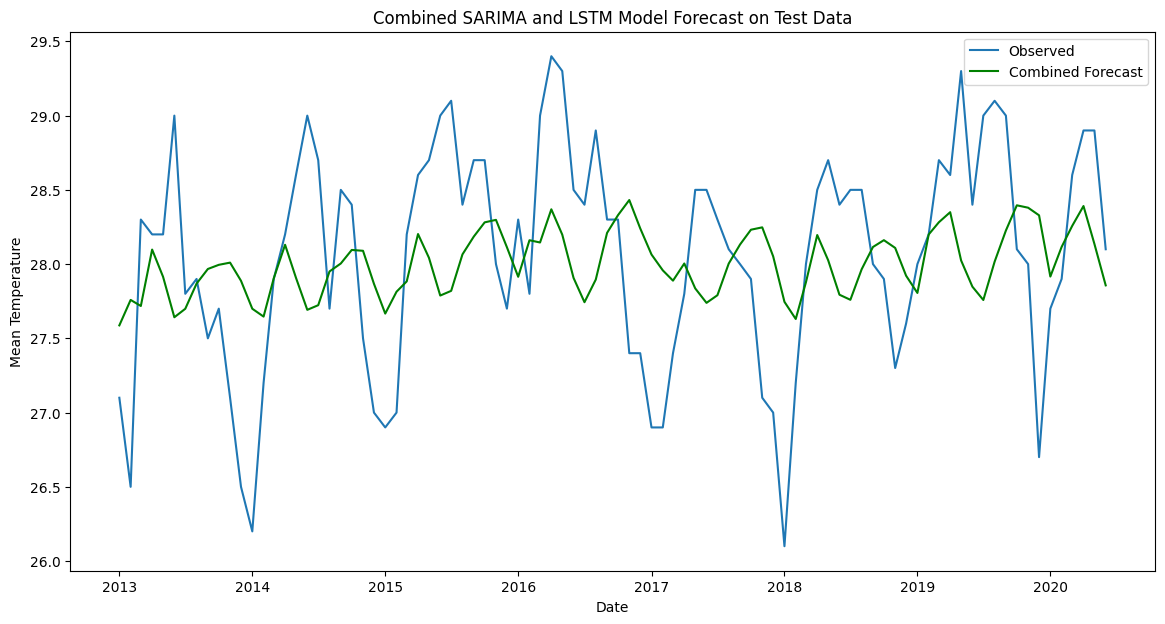

Baseline RMSE: 0.7428
Combined Model RMSE: 27.3546
The combined model does not perform better than the baseline model.


In [ ]:
#Visualization and Comparison

# Plot observed vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index[-test_size:], data['mean_temp'].values[-test_size:], label='Observed')
plt.plot(data.index[-test_size:], combined_test_predictions, label='Combined Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Combined SARIMA and LSTM Model Forecast on Test Data')
plt.legend()
plt.show()

# Calculate baseline model RMSE (e.g., using the mean value as prediction)
baseline_predictions = np.mean(data['mean_temp'].values[-test_size:])
baseline_rmse = np.sqrt(mean_squared_error(data['mean_temp'].values[-test_size:], [baseline_predictions] * test_size))

print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Combined Model RMSE: {combined_rmse:.4f}")

if combined_rmse < baseline_rmse:
    print("The combined model performs better than the baseline model.")
else:
    print("The combined model does not perform better than the baseline model.")


### **13. Conclusion for time series using LSTM**


### **14. Using the XGBoost model**

In [16]:
# Import the libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

Repeating the data preprocessing steps 3,4,7 and continuing

In [17]:
# Reshape for XGBoost
X_train_reshaped = X_train.reshape(X_train.shape[0], look_back)
X_test_reshaped = X_test.reshape(X_test.shape[0], look_back)

In [19]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train_reshaped, Y_train)



Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


**Model training**

In [21]:
# Train the XGBoost model with the best parameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train_reshaped, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Predictions**

In [22]:
# Make predictions
train_predictions = best_xgb_model.predict(X_train_reshaped)
test_predictions = best_xgb_model.predict(X_test_reshaped)

**Model Evaluation**

In [23]:
# Evaluation
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predictions))
train_mae = mean_absolute_error(Y_train, train_predictions)
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
test_mae = mean_absolute_error(Y_test, test_predictions)

print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

Train RMSE: 0.0637, Train MAE: 0.0511
Test RMSE: 0.1161, Test MAE: 0.0939


**Visualization of predictions**

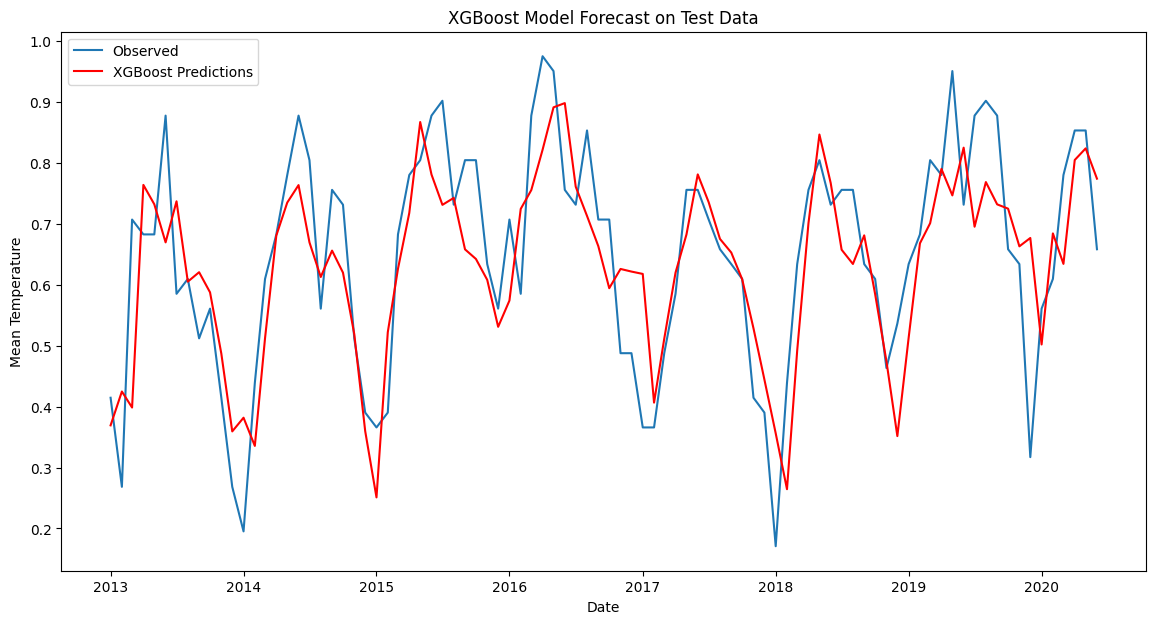

In [24]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[-test_size:], Y_test, label='Observed')
plt.plot(data.index[-test_size:], test_predictions, label='XGBoost Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('XGBoost Model Forecast on Test Data')
plt.legend()
plt.show()

# Save the model
best_xgb_model.save_model('xgboost_model.json')

In [25]:
# Calculate baseline model RMSE (e.g., using the mean value as prediction)
baseline_predictions = np.mean(data['mean_temp'].values[-test_size:])
baseline_rmse = np.sqrt(mean_squared_error(Y_test, [baseline_predictions] * test_size))

print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"XGBoost Model RMSE: {test_rmse:.4f}")

if test_rmse < baseline_rmse:
    print("The XGBoost model performs better than the baseline model.")
else:
    print("The XGBoost model does not perform better than the baseline model.")

Baseline RMSE: 27.4085
XGBoost Model RMSE: 0.1161
The XGBoost model performs better than the baseline model.


### **15. Final Conclusion**
XGBoost model’s RMSE is lower than the baseline RMSE, it indicates that the XGBoost model is effectively capturing the underlying patterns in the data and provides better predictions than the LSTM model and the Combined LSTM model.